#CI Project - NLP
---
##LSTM Models

In [1]:
!pip install -q focal-loss

In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from keras.utils import to_categorical
from focal_loss import SparseCategoricalFocalLoss

## Loading Dataset
---

In [3]:
data = pd.read_csv("sentiment.csv")

In [4]:
classes = ["Negative", "Neutral", "Positive"]
text = data['text']
labels = data['sentiment']

In [14]:
test_data = pd.read_csv('FIFA33.csv')
test_data = test_data['tweet']
test_label = [0,1,0,2,2,0,0,0,1,2,0,1,1,0,2,0,1,1,2,2]

In [15]:
test_data

0                               @fifaworldcup_en Failed
1     @Elam46128932 @caf_online_FR @caf_online_AR @f...
2                                @fifaworldcup_ar Great
3     @Hassanalsobhan @fifaworldcup_ar You are the w...
4                             @fifaworldcup_en My world
5                              @fifaworldcup_en Poverty
6                             @fifaworldcup_ar my pains
7     @fifaworldcup_ar Poor championships, and if th...
8          @fifaworldcup_ar Skill is love and belonging
9                           @fifaworldcup_ar Mixed Asia
10                            @fifaworldcup_en Shouting
11    @fifaworldcup_ar The biggest club in Asia and ...
12                             @fifaworldcup_en Poverty
13    @DSByr2022 @BBCSport Yep. Full coverage [and I...
14    @fifaworldcup_es @juanferquinte10 @JuniorClubS...
15               @fifaworldcup_en The joke of the world
16                         @fifaworldcup_en The dreamer
17                    @fifaworldcup_ar Al-Ahly o

##Preprocess
---

In [16]:
import re

import nltk
import numpy as np
from nltk.corpus import stopwords
from keras.utils import to_categorical

nltk.download('stopwords')
from typing import List

def to_lower(text):
    return text.lower()

def remove_punct(text: str) -> str:
    """Removes punctuation symbols from text.

    Parameters
    ----------
    text : str
        Input text

    Returns
    -------
    str
        Processed string
    """
    return re.sub('[^a-zA-z0-9\s]', '', text)

def remove_stopwords(text: str) -> str:
    """Removes words with high frequency in text but low semantic values.

    Parameters
    ----------
    text : str
        Input text

    Returns
    -------
    str
        Processed text
    """
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_prefix(text: str) -> str:
    """Removes some common twitter prefixes such as "rt" as a sign of the post being retweeted.

    Parameters
    ----------
    text : str
        Input text

    Returns
    -------
    str
        Processed text
    """
    if text.startswith("rt"):
        text = text[2:]
    return text

def convert_labels_to_numerical(label: str, classes: List[str]) -> int:
    """Converts the string categorical label to a numerical label.

    Parameters
    ----------
    label : str
        Categorical label
    classes : List[str]
        List of categories

    Returns
    -------
    int
        Numerical label
    """
    return classes.index(label)

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def clean_data(raw_data, labels):
    # Clean text
    data = raw_data.apply(to_lower)
    data = data.apply(remove_punct)
    data = data.apply(remove_emojis)
    data = data.apply(remove_prefix)
    # data = data.apply(remove_stopwords)
    data = list(data)
    # Clean labels
    classes = ["Negative", "Neutral", "Positive"]
    labels = np.array([convert_labels_to_numerical(label, classes) for label in labels])
    labels = to_categorical(labels, num_classes=3)
    return data, labels

def clean_test_data(raw_data, labels):
    # Clean text
    data = raw_data.apply(to_lower)
    data = data.apply(remove_punct)
    data = data.apply(remove_emojis)
    data = data.apply(remove_prefix)
    # data = data.apply(remove_stopwords)
    data = list(data)
    # Clean labels
    labels = to_categorical(labels, num_classes=3)
    return data, labels

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
cleaned_text, label = clean_data(text, labels)
cleaned_test, test_label = clean_test_data(test_data, test_label)

In [18]:
# Creating a bag of words
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(data['text'])

In [19]:
num_unique_words = len(counter)

In [21]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(np.array(cleaned_text), label, test_size=0.2)

In [22]:
print(f"Number of train samples: {len(train_sentences)}")
print(f"Number of validation samples: {len(val_sentences)}")

Number of train samples: 11096
Number of validation samples: 2775


In [24]:
# Tokenize
from keras.preprocessing.text import Tokenizer

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words, )
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [25]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(np.array(cleaned_test))

In [26]:
from keras.utils import pad_sequences

# Max number of words in a sequence
max_length = np.max([len(i) for i in train_sequences])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

In [27]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

the democrats love to keep people poor and confused in order to make them slaves to their party liberals are for chaos gopdebate trump
[2, 326, 214, 4, 373, 55, 586, 8, 1524, 10, 374, 4, 185, 105, 6689, 4, 65, 162, 851, 35, 13, 6690, 1, 15]
[   2  326  214    4  373   55  586    8 1524   10  374    4  185  105
 6689    4   65  162  851   35   13 6690    1   15    0    0    0    0
    0]


## Training and Model Structure
---

###RNN
---

In [28]:
# Create RNN model
from keras import layers
from keras import regularizers


model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length, name="Embedding"))


model.add(layers.SimpleRNN(64, dropout=0.2, name="RNN_Block"))
model.add(layers.Dense(64, activation="relu", name="Hidden_Layer"))
model.add(layers.Dropout(0.2, name="Dropout"))
model.add(layers.Dense(3, activation="softmax", name="Classifier"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 29, 32)            1013024   
                                                                 
 RNN_Block (SimpleRNN)       (None, 64)                6208      
                                                                 
 Hidden_Layer (Dense)        (None, 64)                4160      
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 Classifier (Dense)          (None, 3)                 195       
                                                                 
Total params: 1,023,587
Trainable params: 1,023,587
Non-trainable params: 0
_________________________________________________________________


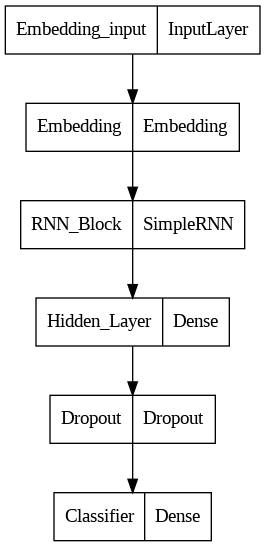

In [29]:
tf.keras.utils.plot_model(model)

In [30]:
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)

metrics = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]

model.compile(loss=loss, optimizer=optim, metrics=metrics)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('rnn_model_best.h5', save_best_only=True)
]

In [31]:
history = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2, callbacks=callbacks)

Epoch 1/20
347/347 - 16s - loss: 0.8776 - accuracy: 0.6236 - recall: 0.4869 - precision: 0.6822 - val_loss: 0.8000 - val_accuracy: 0.6602 - val_recall: 0.5532 - val_precision: 0.7369 - 16s/epoch - 46ms/step
Epoch 2/20
347/347 - 13s - loss: 0.6895 - accuracy: 0.7067 - recall: 0.6088 - precision: 0.7789 - val_loss: 0.8066 - val_accuracy: 0.6548 - val_recall: 0.5650 - val_precision: 0.7031 - 13s/epoch - 37ms/step
Epoch 3/20
347/347 - 12s - loss: 0.4710 - accuracy: 0.8182 - recall: 0.7848 - precision: 0.8502 - val_loss: 0.9079 - val_accuracy: 0.6364 - val_recall: 0.5881 - val_precision: 0.6661 - 12s/epoch - 35ms/step
Epoch 4/20
347/347 - 12s - loss: 0.3184 - accuracy: 0.8841 - recall: 0.8666 - precision: 0.9026 - val_loss: 1.0667 - val_accuracy: 0.6119 - val_recall: 0.5870 - val_precision: 0.6261 - 12s/epoch - 33ms/step
Epoch 5/20
347/347 - 12s - loss: 0.2351 - accuracy: 0.9161 - recall: 0.9039 - precision: 0.9314 - val_loss: 1.1914 - val_accuracy: 0.6086 - val_recall: 0.5697 - val_precisi

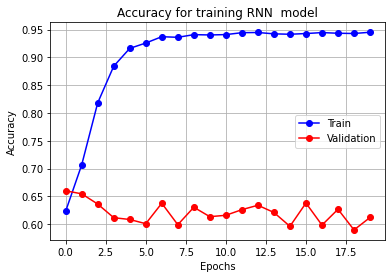

In [32]:
plt.plot(history.history["accuracy"], 'b-o')
plt.plot(history.history["val_accuracy"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-accuracy.png")

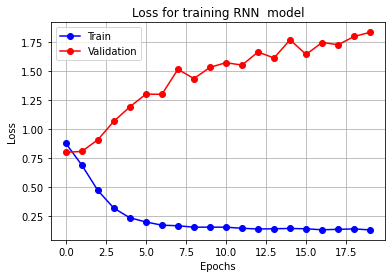

In [33]:
plt.plot(history.history["loss"], 'b-o')
plt.plot(history.history["val_loss"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-loss.png")

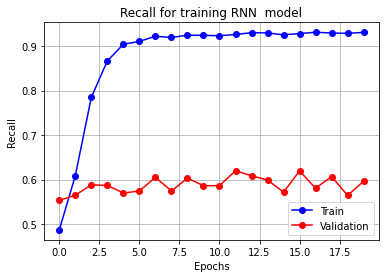

In [34]:
plt.plot(history.history["recall"], 'b-o')
plt.plot(history.history["val_recall"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-recall.png")

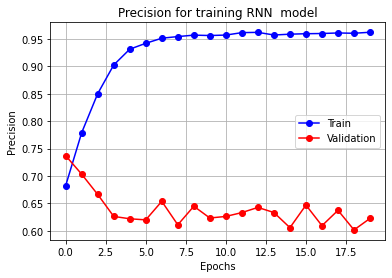

In [35]:
plt.plot(history.history["precision"], 'b-o')
plt.plot(history.history["val_precision"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-precision.png")

In [36]:
model.evaluate(test_padded, test_label)

1/1 [==============================] - 0s 21ms/step - loss: 4.8205 - accuracy: 0.3000 - recall: 0.3000 - precision: 0.3158


[4.8205366134643555,
 0.30000001192092896,
 0.30000001192092896,
 0.31578946113586426]

###LSTM
---

In [37]:
# Create LSTM model
from keras import layers
from keras import regularizers


model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length, name="Embedding"))

model.add(layers.LSTM(64, dropout=0.2, name="LSTM_Block"))
model.add(layers.Dense(64, activation="relu", name="Hidden_Layer"))
model.add(layers.Dropout(0.2, name="Dropout"))
model.add(layers.Dense(3, activation="softmax", name="Classifier"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 29, 32)            1013024   
                                                                 
 LSTM_Block (LSTM)           (None, 64)                24832     
                                                                 
 Hidden_Layer (Dense)        (None, 64)                4160      
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 Classifier (Dense)          (None, 3)                 195       
                                                                 
Total params: 1,042,211
Trainable params: 1,042,211
Non-trainable params: 0
_________________________________________________________________


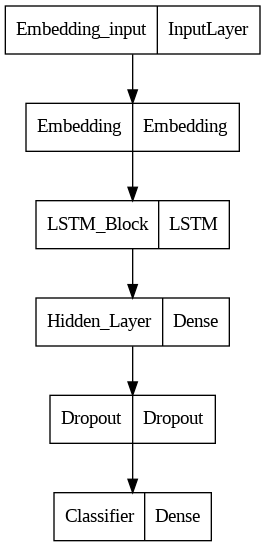

In [38]:
tf.keras.utils.plot_model(model)

In [39]:
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]
model.compile(loss=loss, optimizer=optim, metrics=metrics)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('lstm_model_best.h5', save_best_only=True)
]

In [40]:
history = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2, callbacks=callbacks)

Epoch 1/20
347/347 - 7s - loss: 0.8695 - accuracy: 0.6284 - recall: 0.5144 - precision: 0.6795 - val_loss: 0.7481 - val_accuracy: 0.6804 - val_recall: 0.5276 - val_precision: 0.7922 - 7s/epoch - 21ms/step
Epoch 2/20
347/347 - 2s - loss: 0.6761 - accuracy: 0.7221 - recall: 0.6233 - precision: 0.7852 - val_loss: 0.7354 - val_accuracy: 0.6937 - val_recall: 0.6483 - val_precision: 0.7352 - 2s/epoch - 7ms/step
Epoch 3/20
347/347 - 2s - loss: 0.5296 - accuracy: 0.7995 - recall: 0.7599 - precision: 0.8328 - val_loss: 0.7561 - val_accuracy: 0.7135 - val_recall: 0.6789 - val_precision: 0.7432 - 2s/epoch - 6ms/step
Epoch 4/20
347/347 - 2s - loss: 0.4110 - accuracy: 0.8509 - recall: 0.8282 - precision: 0.8729 - val_loss: 0.8747 - val_accuracy: 0.6908 - val_recall: 0.6667 - val_precision: 0.7069 - 2s/epoch - 7ms/step
Epoch 5/20
347/347 - 2s - loss: 0.3284 - accuracy: 0.8851 - recall: 0.8681 - precision: 0.9018 - val_loss: 0.9725 - val_accuracy: 0.6814 - val_recall: 0.6724 - val_precision: 0.6955 -

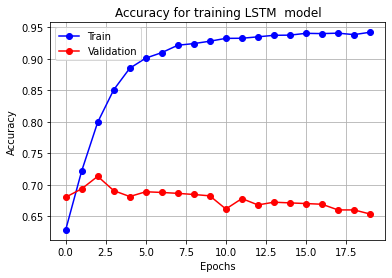

In [41]:
plt.plot(history.history["accuracy"], 'b-o')
plt.plot(history.history["val_accuracy"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-accuracy.png")

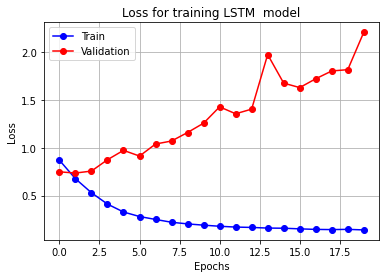

In [42]:
plt.plot(history.history["loss"], 'b-o')
plt.plot(history.history["val_loss"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-loss.png")

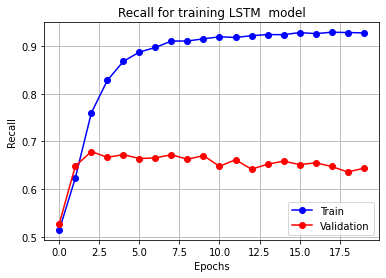

In [43]:
plt.plot(history.history["recall"], 'b-o')
plt.plot(history.history["val_recall"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-recall.png")

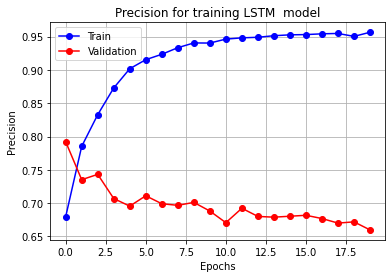

In [44]:
plt.plot(history.history["precision"], 'b-o')
plt.plot(history.history["val_precision"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-precision.png")

In [45]:
model.evaluate(test_padded, test_label)

1/1 [==============================] - 0s 23ms/step - loss: 4.8745 - accuracy: 0.3000 - recall: 0.3000 - precision: 0.3000


[4.874484062194824,
 0.30000001192092896,
 0.30000001192092896,
 0.30000001192092896]

##Bidirectional LSTM
---

In [46]:
# Create LSTM model
from keras import layers
from keras import regularizers


model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length, name="Embedding"))

model.add(layers.Bidirectional(layers.LSTM(64, dropout=0.2, name="Bi_LSTM_Block")))
model.add(layers.Dense(64, activation="relu", name="Hidden_Layer"))
model.add(layers.Dropout(0.2, name="Dropout"))
model.add(layers.Dense(3, activation="softmax", name="Classifier"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 29, 32)            1013024   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 Hidden_Layer (Dense)        (None, 64)                8256      
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 Classifier (Dense)          (None, 3)                 195       
                                                                 
Total params: 1,071,139
Trainable params: 1,071,139
Non-trainable params: 0
____________________________________________

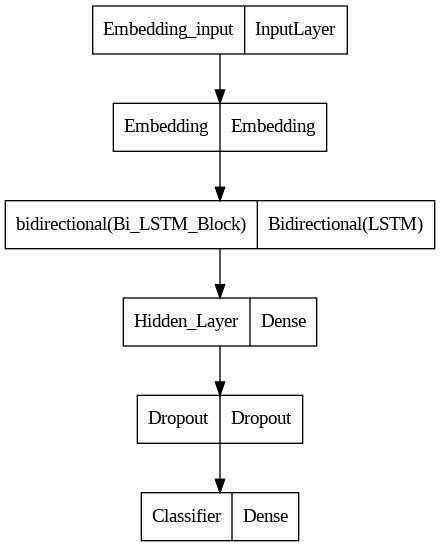

In [47]:
tf.keras.utils.plot_model(model)

In [48]:
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]
model.compile(loss=loss, optimizer=optim, metrics=metrics)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('bilstm_model_best.h5', save_best_only=True)
]

In [49]:
history = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2, callbacks=callbacks)

Epoch 1/20
347/347 - 7s - loss: 0.8408 - accuracy: 0.6356 - recall: 0.5205 - precision: 0.7004 - val_loss: 0.7358 - val_accuracy: 0.6876 - val_recall: 0.5503 - val_precision: 0.7720 - 7s/epoch - 21ms/step
Epoch 2/20
347/347 - 3s - loss: 0.6445 - accuracy: 0.7332 - recall: 0.6516 - precision: 0.7890 - val_loss: 0.7204 - val_accuracy: 0.6829 - val_recall: 0.6148 - val_precision: 0.7379 - 3s/epoch - 9ms/step
Epoch 3/20
347/347 - 3s - loss: 0.4723 - accuracy: 0.8189 - recall: 0.7888 - precision: 0.8465 - val_loss: 0.7832 - val_accuracy: 0.6894 - val_recall: 0.6688 - val_precision: 0.7073 - 3s/epoch - 9ms/step
Epoch 4/20
347/347 - 3s - loss: 0.3514 - accuracy: 0.8702 - recall: 0.8545 - precision: 0.8877 - val_loss: 0.9077 - val_accuracy: 0.6706 - val_recall: 0.6418 - val_precision: 0.6884 - 3s/epoch - 9ms/step
Epoch 5/20
347/347 - 3s - loss: 0.2725 - accuracy: 0.8998 - recall: 0.8868 - precision: 0.9148 - val_loss: 0.9920 - val_accuracy: 0.6695 - val_recall: 0.6544 - val_precision: 0.6825 -

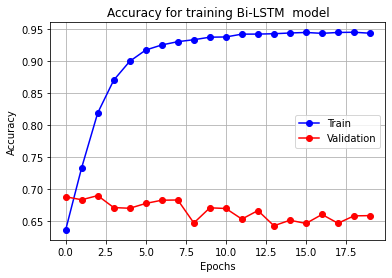

In [50]:
plt.plot(history.history["accuracy"], 'b-o')
plt.plot(history.history["val_accuracy"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for training Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-accuracy.png")

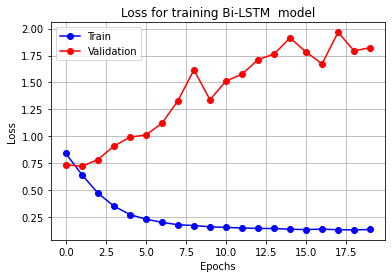

In [51]:
plt.plot(history.history["loss"], 'b-o')
plt.plot(history.history["val_loss"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for training Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-loss.png")

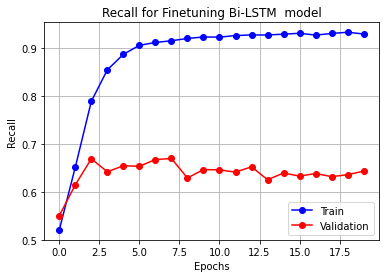

In [52]:
plt.plot(history.history["recall"], 'b-o')
plt.plot(history.history["val_recall"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall for Finetuning Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-recall.png")

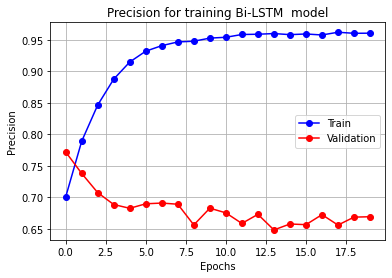

In [53]:
plt.plot(history.history["precision"], 'b-o')
plt.plot(history.history["val_precision"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision for training Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-precision.png")

In [54]:
model.evaluate(test_padded, test_label)

1/1 [==============================] - 0s 23ms/step - loss: 2.1542 - accuracy: 0.3500 - recall: 0.3500 - precision: 0.3684


[2.154244899749756, 0.3499999940395355, 0.3499999940395355, 0.3684210479259491]